# S&P 500 Best and Worst Days Analysis

## Overview
This notebook explores how the S&P 500 has recovered after its worst single-day returns since 1957. The goal is to understand whether buying after a crash has historically led to positive outcomes across different time horizons.

## Key Research Questions
1. How frequently does the market recover after major drawdowns?
2. Which time horizon (5, 10, 30, 60, 90 days) offers the best balance of risk and return?
3. What are the typical probabilities of positive returns and the shape of the return distribution in each window?

## Methodology
- Data Source: S&P 500 daily prices from Stooq covering January 1957–October 2025.
- Sample: 100 worst single-day returns (roughly -3.2% to -20.5%).
- Analysis: For each worst day, compute cumulative returns over the following 5, 10, 30, 60, and 90 trading days.
- Metrics: Success rate, average/median returns, best/worst cases, and probability tables for each horizon.

## Key Findings
- Short horizons (5-30 days) feature low success rates (below 40%) and negative average returns, so they are not reliable for recovery trading.
- Longer horizons (60-90 days) have roughly 60% success probabilities and positive average returns, suggesting patience improves outcomes despite remaining tail risks.
- Even at 90 days, the worst outcomes stay near -34%, meaning position sizing and diversification remain essential.

## Strategy Implications
- Favor a 2-to-3-month holding period when buying after extreme drops.
- Use dollar-cost averaging around these recovery periods to spread execution risk.
- Avoid aggressive, leveraged bets during the first few weeks after a crash because volatility and losses remain elevated.

## Limitations
- Survivorship and regime-shift risks may affect how future crises play out.
- Transaction costs, taxes, and psychological barriers are not represented in this historical study.
- This analysis is for research purposes and is not investment advice.

## Metadata
- Data Source: [S&P 500 Historical Data - Stooq](https://stooq.com/q/d/?s=%5Espx)
- Analysis Date: October 2025
- Sample Period: January 1957 – October 2025

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Fix the path construction - use forward slashes or raw strings
import os

# Method 1: Use forward slashes (recommended)
path = os.path.abspath(os.path.join("..", "04_S&P500_quant_analysis", "01_data", "^spx_d.csv"))

# Alternative Method 2: Use raw string
# path = os.path.abspath(os.path.join("..", r"04_S&P500_quant_analysis\01_data", "^spx_d.csv"))

# Alternative Method 3: Use pathlib (modern approach)
# from pathlib import Path
# path = Path("..") / "04_S&P500_quant_analysis" / "01_data" / "^spx_d.csv"
print(f"Path exists: {os.path.exists(path)}")

# Read the CSV file
df = pd.read_csv(path)

# lower case column names for easier access
df.columns = [col.lower() for col in df.columns]

# Set the 'date' column as the index and convert it to datetime
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Show the first few rows of the dataframe
df.head()

Path exists: True


,open,high,low,close,volume
date,,,,,
1789-05-01,0.51,0.51,0.51,0.51,0.0
1789-06-01,0.51,0.51,0.51,0.51,0.0
1789-07-01,0.50,0.50,0.50,0.50,0.0
1789-08-01,0.50,0.51,0.50,0.51,0.0
1789-09-01,0.51,0.51,0.50,0.51,0.0


In [35]:
# filter DatetimeIndex higher than year 1957
df = df[df.index > '1957-01-01']

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17355 entries, 1957-01-02 to 2025-12-12
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    17355 non-null  float64
 1   high    17355 non-null  float64
 2   low     17355 non-null  float64
 3   close   17355 non-null  float64
 4   volume  17355 non-null  float64
dtypes: float64(5)
memory usage: 813.5 KB


In [36]:
df.shape

(17355, 5)

In [37]:
# # plot close prices over time
# plt.figure(figsize=(14, 7))
# plt.plot(df.index, df['close'], label='Close Price')
# plt.title('S&P 500 Close Prices Over Time')
# plt.xlabel('Date')
# plt.ylabel('Close Price')
# plt.legend()
# plt.grid()
# plt.show()

In [38]:
# Calculate simple returns with pct_change()
simple_returns = df['close'].pct_change().fillna(0)

# Calculate log returns
log_returns = (1 + simple_returns).apply(np.log)

# Cumulative sum of simple returns (not correct for compounding)
cumsum_simple = simple_returns.cumsum()

In [39]:
simple_returns.tail()

date
2025-12-08   -0.003477
2025-12-09   -0.000876
2025-12-10    0.006749
2025-12-11    0.002079
2025-12-12   -0.010664
Name: close, dtype: float64

In [40]:
# top 100 worst days
worst_days = simple_returns.nsmallest(100)

# top 100 best days
best_days = simple_returns.nlargest(100)

# print results
print("Top 100 Worst Days:")
print(worst_days)

print("\nTop 100 Best Days:")
print(best_days)

Top 100 Worst Days:
date
1987-10-19   -0.204669
2020-03-16   -0.119841
2020-03-12   -0.095113
2008-10-15   -0.090350
2008-12-01   -0.089295
                ...   
2018-10-10   -0.032864
2022-06-16   -0.032512
2018-12-04   -0.032365
2010-05-06   -0.032354
2002-09-27   -0.032259
Name: close, Length: 100, dtype: float64

Top 100 Best Days:
date
2008-10-13    0.115800
2008-10-28    0.107890
2025-04-09    0.095154
2020-03-24    0.093828
2020-03-13    0.092871
                ...   
2000-10-13    0.033381
2000-04-25    0.033276
2003-01-02    0.033200
2000-04-17    0.033084
2010-05-27    0.032876
Name: close, Length: 100, dtype: float64


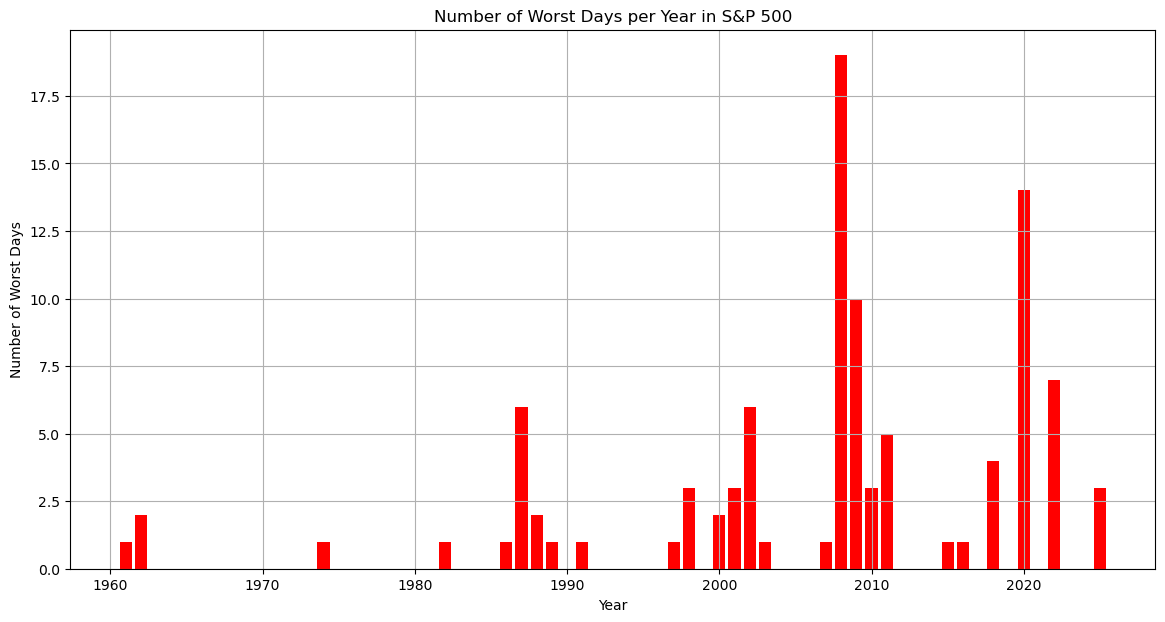

In [41]:
# count worst_days per year
worst_days_per_year = worst_days.groupby(worst_days.index.year).count()

# plot worst days per year
plt.figure(figsize=(14, 7))
plt.bar(worst_days_per_year.index, worst_days_per_year.values, color='red')
plt.title('Number of Worst Days per Year in S&P 500')
plt.xlabel('Year')
plt.ylabel('Number of Worst Days')
plt.grid()
plt.show()

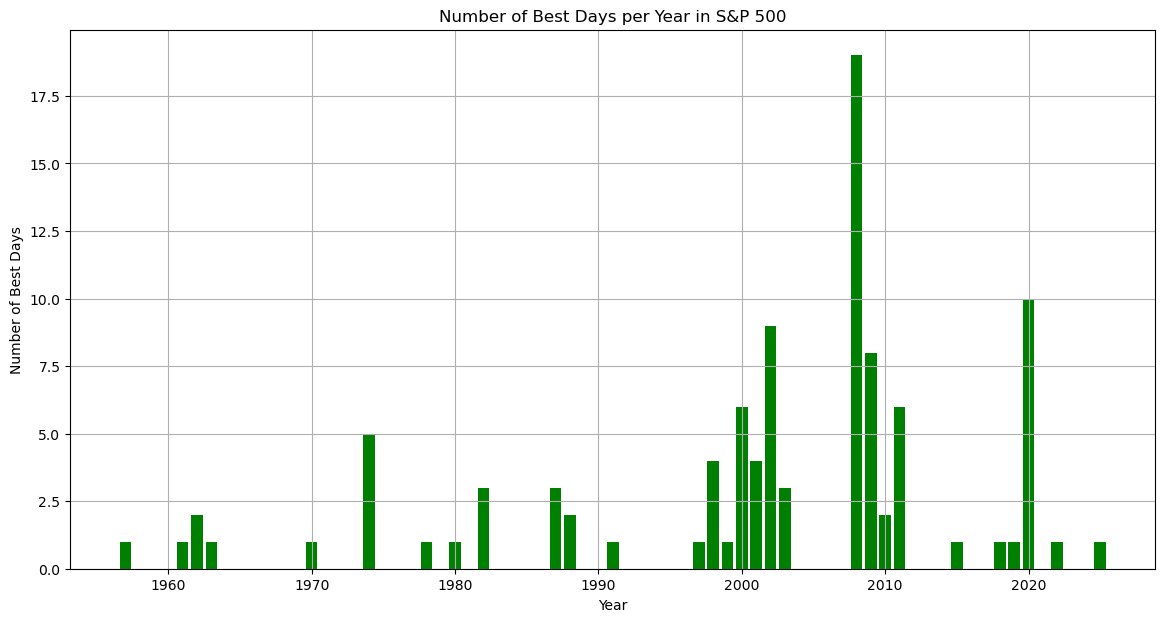

In [42]:
# count best_days per year
best_days_per_year = best_days.groupby(best_days.index.year).count()      

# plot best  days per year
plt.figure(figsize=(14, 7))
plt.bar(best_days_per_year.index, best_days_per_year.values, color='green')
plt.title('Number of Best Days per Year in S&P 500')
plt.xlabel('Year')
plt.ylabel('Number of Best Days')
plt.grid()
plt.show()

In [43]:
# Day After Analysis
# Calculate the average return of the day after each worst day
def analyze_worst_to_next_probability(worst_days, window_sizes):
    results = {}
    for window in window_sizes:
        future_returns_list = []
        for day in worst_days.index:
            try:
                # Get the index position of this day
                day_idx = simple_returns.index.get_loc(day)
                # Get the returns for the next 'window' days (trading days, not calendar days)
                if day_idx + window < len(simple_returns):
                    future_returns = simple_returns.iloc[day_idx + 1:day_idx + 1 + window]
                    cumulative_return = future_returns.sum()
                    future_returns_list.append(cumulative_return)
            except (KeyError, IndexError):
                continue
        
        if future_returns_list:
            results[window] = {
                'mean_return': np.mean(future_returns_list),
                'median_return': np.median(future_returns_list),
                'positive_count': sum(1 for r in future_returns_list if r > 0),
                'total_count': len(future_returns_list),
                'probability_positive': sum(1 for r in future_returns_list if r > 0) / len(future_returns_list)
            }
    return results

# Run the analysis
# window_sizes = [1, 5, 10, 30]
window_sizes = [1]
recovery_probabilities = analyze_worst_to_next_probability(worst_days, window_sizes)

# Display results
print("Analysis: Returns AFTER Worst Days")
print("=" * 50)
for window, stats in recovery_probabilities.items():
    print(f"\n{window}-Day Window After Worst Days:")
    print(f"  Mean return: {stats['mean_return']:+.2%}")
    print(f"  Median return: {stats['median_return']:+.2%}")
    print(f"  Probability of positive return: {stats['probability_positive']:.1%}")
    print(f"  Positive outcomes: {stats['positive_count']}/{stats['total_count']}")

Analysis: Returns AFTER Worst Days

1-Day Window After Worst Days:
  Mean return: +0.36%
  Median return: +0.40%
  Probability of positive return: 56.0%
  Positive outcomes: 56/100


In [44]:
# Calculate the average return of the day after each best day
def analyze_best_to_next_probability(best_days, window_sizes):
    results = {}
    for window in window_sizes:
        future_returns_list = []
        for day in best_days.index:
            try:
                # Get the index position of this day
                day_idx = simple_returns.index.get_loc(day)
                # Get the returns for the next 'window' days (trading days, not calendar days)
                if day_idx + window < len(simple_returns):
                    future_returns = simple_returns.iloc[day_idx + 1:day_idx + 1 + window]
                    cumulative_return = future_returns.sum()
                    future_returns_list.append(cumulative_return)
            except (KeyError, IndexError):
                continue
        
        if future_returns_list:
            results[window] = {
                'mean_return': np.mean(future_returns_list),
                'median_return': np.median(future_returns_list),
                'positive_count': sum(1 for r in future_returns_list if r > 0),
                'negative_count': sum(1 for r in future_returns_list if r < 0),
                'total_count': len(future_returns_list),
                'probability_positive': sum(1 for r in future_returns_list if r > 0) / len(future_returns_list),
                'probability_negative': sum(1 for r in future_returns_list if r < 0) / len(future_returns_list)
            }
    return results

# Run the analysis for best days
window_sizes_best = [1]
best_day_probabilities = analyze_best_to_next_probability(best_days, window_sizes_best)

# Display results
print("Analysis: Returns AFTER Best Days")
print("=" * 50)
for window, stats in best_day_probabilities.items():
    print(f"\n{window}-Day Window After Best Days:")
    print(f"  Mean return: {stats['mean_return']:+.2%}")
    print(f"  Median return: {stats['median_return']:+.2%}")
    print(f"  Probability of positive return: {stats['probability_positive']:.1%}")
    print(f"  Probability of negative return (pullback): {stats['probability_negative']:.1%}")
    print(f"  Positive outcomes: {stats['positive_count']}/{stats['total_count']}")
    print(f"  Negative outcomes: {stats['negative_count']}/{stats['total_count']}")

Analysis: Returns AFTER Best Days

1-Day Window After Best Days:
  Mean return: -0.31%
  Median return: -0.16%
  Probability of positive return: 47.0%
  Probability of negative return (pullback): 53.0%
  Positive outcomes: 47/100
  Negative outcomes: 53/100


In [45]:
# window size from best and worst days
window_size = [5, 10, 30, 60, 90] # days

# Fixed function that calculates the cumulative sum of simple returns, from one of the worst days, for a given window size
def cumulative_return_from_day(day, window):
    try:
        start_idx = simple_returns.index.get_loc(day)
        end_idx = min(start_idx + window, len(simple_returns))  # Prevent index overflow
        
        # Check if we have enough data points
        if end_idx - start_idx < window:
            # If not enough data, pad with the available data
            available_data = simple_returns.iloc[start_idx:end_idx]
            # Create a series with the requested window size, filling missing values with 0
            padded_data = pd.Series(index=range(window), dtype=float)
            padded_data.iloc[:len(available_data)] = available_data.values
            padded_data = padded_data.fillna(0)
            return padded_data.cumsum()
        else:
            return simple_returns.iloc[start_idx:end_idx].cumsum()
    except (KeyError, IndexError):
        # If date doesn't exist, return a series of zeros
        return pd.Series([0] * window).cumsum()

# call the function for each of the worst days and each window size
cumulative_worst = {window: [] for window in window_size}
successful_days = {window: [] for window in window_size}  # Track which days worked

for day in worst_days.index:
    for window in window_size:
        cum_ret = cumulative_return_from_day(day, window)
        if not cum_ret.isna().all():  # Only add if not all NaN
            cumulative_worst[window].append(cum_ret)
            if window == 5:  # Track successful days for the first window only
                successful_days[window].append(day)

# convert lists to DataFrames with proper indexing
for window in window_size:
    if cumulative_worst[window]:  # Only if we have data
        cumulative_worst[window] = pd.DataFrame(cumulative_worst[window]).T
        # Set proper column names (day indices)
        cumulative_worst[window].columns = range(len(cumulative_worst[window].columns))
    else:
        cumulative_worst[window] = pd.DataFrame()  # Empty DataFrame

print(f"Successfully processed {len(cumulative_worst[5].columns)} worst days for 5-day window")
cumulative_worst[5].head()

Successfully processed 100 worst days for 5-day window


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
date,,,,,,,,,,,,,,,,,,,,,
1961-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-04-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-04-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1961-04-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Running final recovery analysis...
Processing 5-day window...
  Successfully processed 100 recovery events
Processing 10-day window...
  Successfully processed 100 recovery events
Processing 30-day window...
  Successfully processed 100 recovery events
Processing 60-day window...
  Successfully processed 100 recovery events
Processing 90-day window...
  Successfully processed 100 recovery events


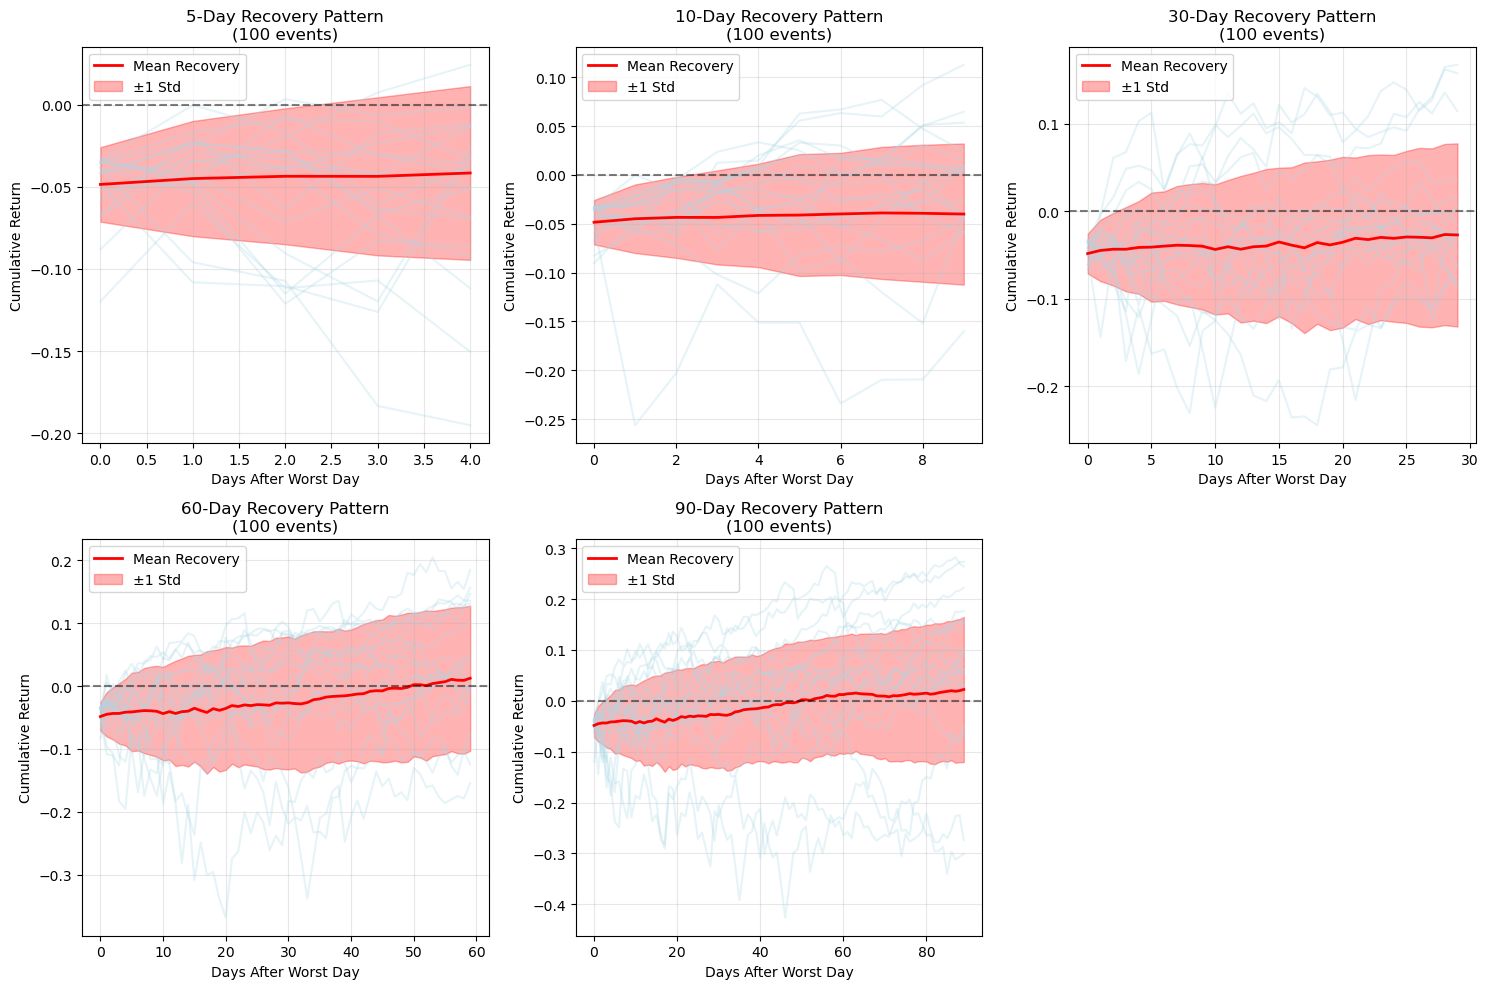


S&P 500 RECOVERY ANALYSIS AFTER WORST DAYS

5-Day Recovery Window:
  • Average return: -4.15%
  • Probability of positive return: 19%
  • Success rate: 19/100 events
  • Median return: -3.69%
  • Best case: +10.27%
  • Worst case: -19.52%

10-Day Recovery Window:
  • Average return: -4.01%
  • Probability of positive return: 32%
  • Success rate: 32/100 events
  • Median return: -3.04%
  • Best case: +11.27%
  • Worst case: -28.74%

30-Day Recovery Window:
  • Average return: -2.73%
  • Probability of positive return: 39%
  • Success rate: 39/100 events
  • Median return: -2.29%
  • Best case: +20.45%
  • Worst case: -32.30%

60-Day Recovery Window:
  • Average return: +1.24%
  • Probability of positive return: 59%
  • Success rate: 59/100 events
  • Median return: +1.87%
  • Best case: +26.97%
  • Worst case: -33.78%

90-Day Recovery Window:
  • Average return: +2.23%
  • Probability of positive return: 61%
  • Success rate: 61/100 events
  • Median return: +4.30%
  • Best case: +31.

In [46]:
# CLEAN RECOVERY ANALYSIS - Final Version
def analyze_recovery_patterns_final():
    """Final clean recovery pattern analysis"""
    
    recovery_stats = {}
    
    for window in window_size:
        print(f"Processing {window}-day window...")
        
        all_recovery_paths = []
        valid_dates = []
        
        for day in worst_days.index:
            try:
                # Find the position of this worst day in our returns series
                day_idx = simple_returns.index.get_loc(day)
                
                # Check if we have enough data after this day
                if day_idx + window <= len(simple_returns):
                    # Get the recovery path (including the worst day itself)
                    recovery_path = simple_returns.iloc[day_idx:day_idx + window].cumsum()
                    all_recovery_paths.append(recovery_path.values)
                    valid_dates.append(day)
                    
            except (KeyError, IndexError):
                continue
        
        if all_recovery_paths:
            # Convert to DataFrame: rows = days, columns = recovery events
            recovery_df = pd.DataFrame(all_recovery_paths).T
            recovery_df.index = range(window)  # Days 0, 1, 2, ..., window-1
            
            # Calculate statistics
            mean_recovery = recovery_df.mean(axis=1)
            median_recovery = recovery_df.median(axis=1)
            std_recovery = recovery_df.std(axis=1)
            
            recovery_stats[window] = {
                'data': recovery_df,
                'mean': mean_recovery,
                'median': median_recovery,
                'std': std_recovery,
                'count': len(all_recovery_paths),
                'valid_dates': valid_dates
            }
            
            print(f"  Successfully processed {len(all_recovery_paths)} recovery events")
        else:
            print(f"  No valid recovery events found")
    
    return recovery_stats

# Run the analysis
print("Running final recovery analysis...")
recovery_analysis = analyze_recovery_patterns_final()

# Visualization
plt.figure(figsize=(15, 10))

for i, window in enumerate(window_size):
    if window in recovery_analysis:
        plt.subplot(2, 3, i+1)
        
        # Plot sample recovery paths
        data = recovery_analysis[window]['data']
        sample_data = data.sample(min(20, data.shape[1]), axis=1)
        plt.plot(sample_data, alpha=0.3, color='lightblue')
        
        # Plot mean and confidence bands
        mean_recovery = recovery_analysis[window]['mean']
        std_recovery = recovery_analysis[window]['std']
        
        days = range(len(mean_recovery))
        plt.plot(days, mean_recovery, 'r-', linewidth=2, label='Mean Recovery')
        plt.fill_between(days, 
                        mean_recovery - std_recovery, 
                        mean_recovery + std_recovery, 
                        alpha=0.3, color='red', label='±1 Std')
        
        plt.title(f'{window}-Day Recovery Pattern\n({recovery_analysis[window]["count"]} events)')
        plt.xlabel('Days After Worst Day')
        plt.ylabel('Cumulative Return')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Final Statistics
print("\n" + "="*60)
print("S&P 500 RECOVERY ANALYSIS AFTER WORST DAYS")
print("="*60)

for window in window_size:
    if window in recovery_analysis:
        stats = recovery_analysis[window]
        
        # Get final day returns for all recovery events
        final_day_returns = stats['data'].iloc[-1]
        mean_return = stats['mean'].iloc[-1]
        
        # Calculate probability statistics
        positive_outcomes = (final_day_returns > 0).sum()
        total_outcomes = len(final_day_returns)
        prob_positive = positive_outcomes / total_outcomes
        
        print(f"\n{window}-Day Recovery Window:")
        print(f"  • Average return: {mean_return:+.2%}")
        print(f"  • Probability of positive return: {prob_positive:.0%}")
        print(f"  • Success rate: {positive_outcomes}/{total_outcomes} events")
        print(f"  • Median return: {final_day_returns.median():+.2%}")
        print(f"  • Best case: {final_day_returns.max():+.2%}")
        print(f"  • Worst case: {final_day_returns.min():+.2%}")

print("\n" + "="*60)
print("="*60)

Running analysis for patterns AFTER best days...
Processing 5-day window after best days...
  Successfully processed 100 periods after best days
Processing 10-day window after best days...
  Successfully processed 100 periods after best days
Processing 30-day window after best days...
  Successfully processed 100 periods after best days
Processing 60-day window after best days...
  Successfully processed 100 periods after best days
Processing 90-day window after best days...
  Successfully processed 100 periods after best days


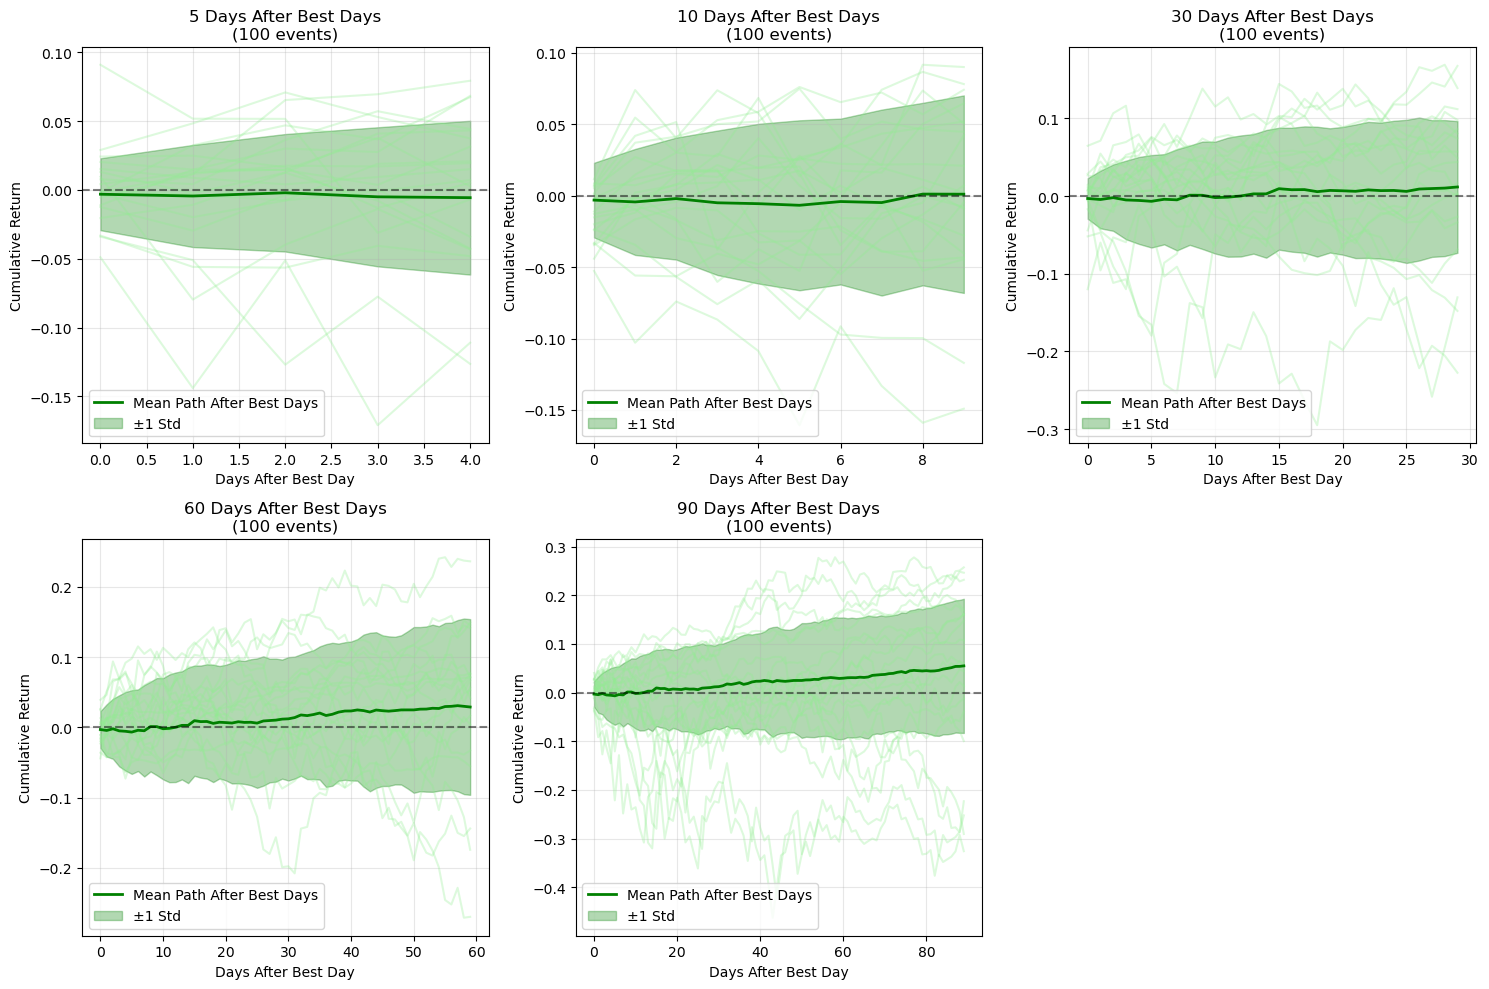


S&P 500 PATTERNS AFTER THE TOP 100 BEST DAYS

5 Days After Big Rally:
  • Average return: -0.56%
  • Probability of continued gains: 57%
  • Probability of pullback: 43%
  • Continued gains: 57/100 events
  • Pullbacks: 43/100 events
  • Median return: +0.53%
  • Best case: +11.51%
  • Worst case: -18.59%

10 Days After Big Rally:
  • Average return: +0.10%
  • Probability of continued gains: 59%
  • Probability of pullback: 41%
  • Continued gains: 59/100 events
  • Pullbacks: 41/100 events
  • Median return: +0.77%
  • Best case: +13.83%
  • Worst case: -24.04%

30 Days After Big Rally:
  • Average return: +1.17%
  • Probability of continued gains: 60%
  • Probability of pullback: 40%
  • Continued gains: 60/100 events
  • Pullbacks: 40/100 events
  • Median return: +1.64%
  • Best case: +16.79%
  • Worst case: -22.74%

60 Days After Big Rally:
  • Average return: +2.90%
  • Probability of continued gains: 66%
  • Probability of pullback: 34%
  • Continued gains: 66/100 events
  • P

In [47]:
# ================================================================
# ANALYSIS OF PATTERNS AFTER THE TOP 100 BEST DAYS
# ================================================================

# CLEAN ANALYSIS FOR BEST DAYS - What happens after major rallies?
def analyze_patterns_after_best_days():
    """Analyze what happens after the top 100 best market days"""
    
    best_day_stats = {}
    
    for window in window_size:
        print(f"Processing {window}-day window after best days...")
        
        all_paths_after_best = []
        valid_dates = []
        
        for day in best_days.index:
            try:
                # Find the position of this best day in our returns series
                day_idx = simple_returns.index.get_loc(day)
                
                # Check if we have enough data after this day
                if day_idx + window <= len(simple_returns):
                    # Get the path AFTER the best day (starting from day+1, not including the best day itself)
                    path_after = simple_returns.iloc[day_idx + 1:day_idx + 1 + window].cumsum()
                    all_paths_after_best.append(path_after.values)
                    valid_dates.append(day)
                    
            except (KeyError, IndexError):
                continue
        
        if all_paths_after_best:
            # Convert to DataFrame: rows = days, columns = events after best days
            paths_df = pd.DataFrame(all_paths_after_best).T
            paths_df.index = range(window)  # Days 1, 2, 3, ..., window after best day
            
            # Calculate statistics
            mean_path = paths_df.mean(axis=1)
            median_path = paths_df.median(axis=1)
            std_path = paths_df.std(axis=1)
            
            best_day_stats[window] = {
                'data': paths_df,
                'mean': mean_path,
                'median': median_path,
                'std': std_path,
                'count': len(all_paths_after_best),
                'valid_dates': valid_dates
            }
            
            print(f"  Successfully processed {len(all_paths_after_best)} periods after best days")
        else:
            print(f"  No valid periods found")
    
    return best_day_stats

# Run the analysis for best days
print("Running analysis for patterns AFTER best days...")
best_day_analysis = analyze_patterns_after_best_days()

# Visualization - What happens AFTER best days
plt.figure(figsize=(15, 10))

for i, window in enumerate(window_size):
    if window in best_day_analysis:
        plt.subplot(2, 3, i+1)
        
        # Plot sample paths after best days
        data = best_day_analysis[window]['data']
        sample_data = data.sample(min(20, data.shape[1]), axis=1)
        plt.plot(sample_data, alpha=0.3, color='lightgreen')
        
        # Plot mean and confidence bands
        mean_path = best_day_analysis[window]['mean']
        std_path = best_day_analysis[window]['std']
        
        days = range(len(mean_path))
        plt.plot(days, mean_path, 'g-', linewidth=2, label='Mean Path After Best Days')
        plt.fill_between(days, 
                        mean_path - std_path, 
                        mean_path + std_path, 
                        alpha=0.3, color='green', label='±1 Std')
        
        plt.title(f'{window} Days After Best Days\n({best_day_analysis[window]["count"]} events)')
        plt.xlabel('Days After Best Day')
        plt.ylabel('Cumulative Return')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Statistics for what happens AFTER best days
print("\n" + "="*60)
print("S&P 500 PATTERNS AFTER THE TOP 100 BEST DAYS")
print("="*60)

for window in window_size:
    if window in best_day_analysis:
        stats = best_day_analysis[window]
        
        # Get final day returns for all periods after best days
        final_day_returns = stats['data'].iloc[-1]
        mean_return = stats['mean'].iloc[-1]
        
        # Calculate probability statistics
        positive_outcomes = (final_day_returns > 0).sum()
        total_outcomes = len(final_day_returns)
        prob_positive = positive_outcomes / total_outcomes
        
        # Calculate negative outcomes (pullbacks after rallies)
        negative_outcomes = (final_day_returns < 0).sum()
        prob_negative = negative_outcomes / total_outcomes
        
        print(f"\n{window} Days After Big Rally:")
        print(f"  • Average return: {mean_return:+.2%}")
        print(f"  • Probability of continued gains: {prob_positive:.0%}")
        print(f"  • Probability of pullback: {prob_negative:.0%}")
        print(f"  • Continued gains: {positive_outcomes}/{total_outcomes} events")
        print(f"  • Pullbacks: {negative_outcomes}/{total_outcomes} events")
        print(f"  • Median return: {final_day_returns.median():+.2%}")
        print(f"  • Best case: {final_day_returns.max():+.2%}")
        print(f"  • Worst case: {final_day_returns.min():+.2%}")

print("\n" + "="*60)
print("="*60)

# COMPARATIVE ANALYSIS: Best Days vs Worst Days
print("\n" + "="*80)
print("COMPARATIVE ANALYSIS: AFTER BEST DAYS vs AFTER WORST DAYS")
print("="*80)

# Create comparison table
comparison_data = []
for window in window_size:
    if window in recovery_analysis and window in best_day_analysis:
        # After worst days (recovery analysis)
        worst_mean = recovery_analysis[window]['mean'].iloc[-1]
        worst_prob_positive = (recovery_analysis[window]['data'].iloc[-1] > 0).mean()
        
        # After best days
        best_mean = best_day_analysis[window]['mean'].iloc[-1]
        best_prob_positive = (best_day_analysis[window]['data'].iloc[-1] > 0).mean()
        
        comparison_data.append({
            'Window': f'{window} days',
            'After_Worst_Mean': f'{worst_mean:+.2%}',
            'After_Worst_Success': f'{worst_prob_positive:.0%}',
            'After_Best_Mean': f'{best_mean:+.2%}',
            'After_Best_Success': f'{best_prob_positive:.0%}',
            'Difference': f'{best_mean - worst_mean:+.2%}'
        })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n" + "="*80)
print("STRATEGIC IMPLICATIONS:")
print("• Market timing: Compare recovery odds vs post-rally risks")
print("• Contrarian vs momentum: Which approach works better at different horizons?")
print("• Portfolio rebalancing: When to buy dips vs take profits")
print("="*80)

In [48]:
# FIXED VERSION - Create DataFrame with proper structure
# Create DataFrames instead of adding columns to Series
worst_days_df = pd.DataFrame({
    'return': worst_days.values,
    'day_type': 'worst'
}, index=worst_days.index)

best_days_df = pd.DataFrame({
    'return': best_days.values,
    'day_type': 'best'
}, index=best_days.index)

# concatenate the two dataframes
worst_and_best = pd.concat([worst_days_df, best_days_df])

# sort by index (date)
worst_and_best = worst_and_best.sort_index()

# print shape and head
print("Combined DataFrame shape:", worst_and_best.shape)
print("\nFirst few rows:")
print(worst_and_best.head())

print("\nLast few rows:")
print(worst_and_best.tail())

print("\nValue counts by day type:")
print(worst_and_best['day_type'].value_counts())

print("\nSample of worst days:")
print(worst_and_best[worst_and_best['day_type'] == 'worst'].head())

print("\nSample of best days:")
print(worst_and_best[worst_and_best['day_type'] == 'best'].head())

Combined DataFrame shape: (200, 2)

First few rows:
              return day_type
date                         
1957-10-23  0.044895     best
1961-04-17  0.034805     best
1961-04-18 -0.036109    worst
1962-05-28 -0.066756    worst
1962-05-29  0.046486     best

Last few rows:
              return day_type
date                         
2022-11-10  0.055434     best
2025-04-03 -0.048396    worst
2025-04-04 -0.059750    worst
2025-04-09  0.095154     best
2025-04-10 -0.034608    worst

Value counts by day type:
day_type
best     100
worst    100
Name: count, dtype: int64

Sample of worst days:
              return day_type
date                         
1961-04-18 -0.036109    worst
1962-05-28 -0.066756    worst
1962-06-04 -0.035534    worst
1974-11-18 -0.036713    worst
1982-10-25 -0.039689    worst

Sample of best days:
              return day_type
date                         
1957-10-23  0.044895     best
1961-04-17  0.034805     best
1962-05-29  0.046486     best
1962-06-28  0.03441

In [49]:
# lambda function to calculate the difference in days between two consecutive dates
worst_and_best['days_since_last'] = worst_and_best.index.to_series().diff().dt.days.fillna(0).astype(int)

# print the first few rows to verify
print("\nFirst few rows with days_since_last:")
print(worst_and_best.head())


First few rows with days_since_last:
              return day_type  days_since_last
date                                          
1957-10-23  0.044895     best                0
1961-04-17  0.034805     best             1272
1961-04-18 -0.036109    worst                1
1962-05-28 -0.066756    worst              405
1962-05-29  0.046486     best                1


In [50]:
worst_and_best.head(10)

,return,day_type,days_since_last
date,,,
1957-10-23,0.044895,best,0
1961-04-17,0.034805,best,1272
1961-04-18,-0.036109,worst,1
1962-05-28,-0.066756,worst,405
1962-05-29,0.046486,best,1
1962-06-04,-0.035534,worst,6
1962-06-28,0.034411,best,24
1963-11-26,0.039793,best,516
1970-05-27,0.050224,best,2374


PROBABILITY ANALYSIS: WORST DAYS FOLLOWED BY BEST DAYS

Analyzing 5-day window...
  • Probability: 41.0%
  • Success cases: 41/100
  • Average days to recovery: 2.6

Analyzing 10-day window...
  • Probability: 61.0%
  • Success cases: 61/100
  • Average days to recovery: 4.2

Analyzing 30-day window...
  • Probability: 72.0%
  • Success cases: 72/100
  • Average days to recovery: 6.7

Analyzing 60-day window...
  • Probability: 76.0%
  • Success cases: 76/100
  • Average days to recovery: 8.6

Analyzing 90-day window...
  • Probability: 79.0%
  • Success cases: 79/100
  • Average days to recovery: 11.1

SUMMARY: PROBABILITY OF BEST DAY AFTER WORST DAY
 Window (Days) Probability Success Rate Avg Days to Recovery Median Days Range
             5       41.0%       41/100                  2.6         2.0   1-5
            10       61.0%       61/100                  4.2         4.0  1-10
            30       72.0%       72/100                  6.7         5.0  1-28
            60       76.

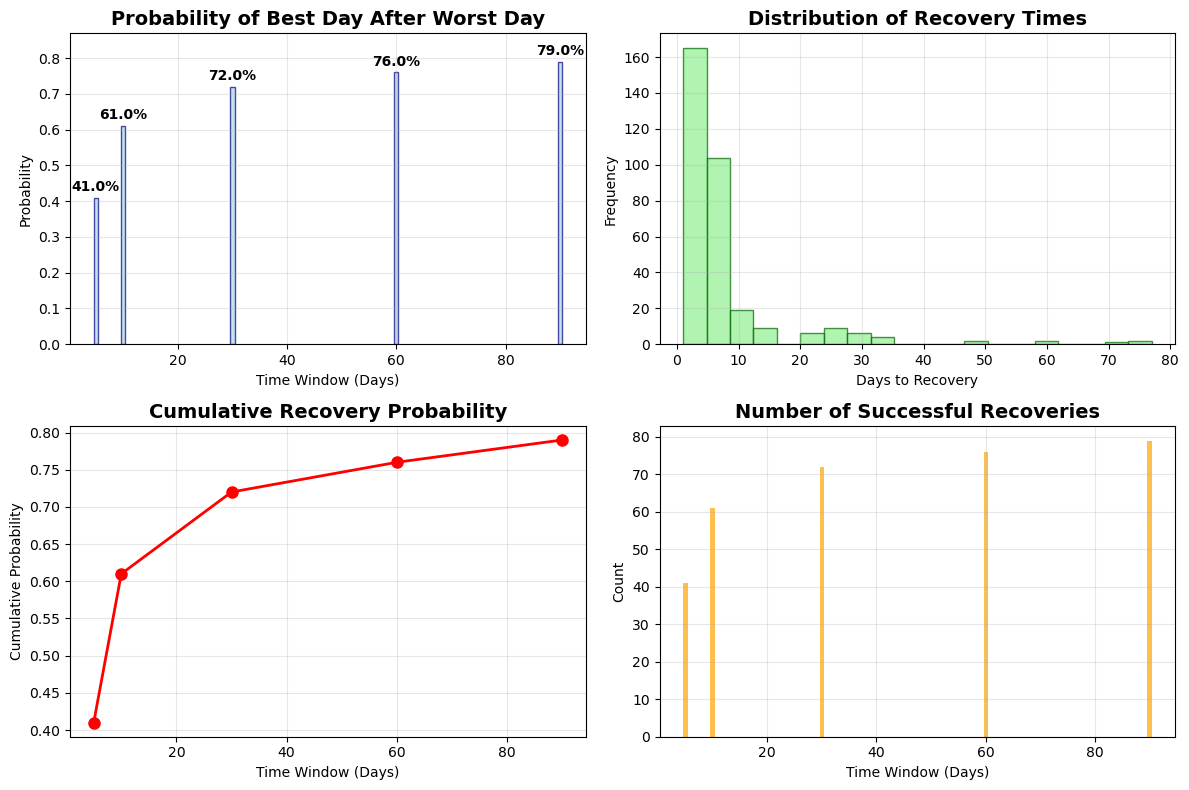


SAMPLE SUCCESSFUL RECOVERY CASES (30-day window)
 1. Worst day: 1962-05-28 (-6.68%)
    Best day:  1962-05-29 (+4.65%)
    Recovery:  1 days

 2. Worst day: 1962-06-04 (-3.55%)
    Best day:  1962-06-28 (+3.44%)
    Recovery:  24 days

 3. Worst day: 1982-10-25 (-3.97%)
    Best day:  1982-11-03 (+3.91%)
    Recovery:  9 days

 4. Worst day: 1987-10-16 (-5.16%)
    Best day:  1987-10-20 (+5.33%)
    Recovery:  4 days

 5. Worst day: 1987-10-19 (-20.47%)
    Best day:  1987-10-20 (+5.33%)
    Recovery:  1 days

 6. Worst day: 1987-10-22 (-3.92%)
    Best day:  1987-10-29 (+4.93%)
    Recovery:  7 days

 7. Worst day: 1987-10-26 (-8.28%)
    Best day:  1987-10-29 (+4.93%)
    Recovery:  3 days

 8. Worst day: 1997-10-27 (-6.87%)
    Best day:  1997-10-28 (+5.12%)
    Recovery:  1 days

 9. Worst day: 1998-08-04 (-3.62%)
    Best day:  1998-09-01 (+3.86%)
    Recovery:  28 days

10. Worst day: 1998-08-27 (-3.84%)
    Best day:  1998-09-01 (+3.86%)
    Recovery:  5 days



In [51]:
# ================================================================
# PROBABILITY ANALYSIS: WORST DAYS FOLLOWED BY BEST DAYS
# ================================================================

def analyze_worst_to_best_probability(worst_and_best_df, window_sizes):
    """
    Calculate the probability that after a worst day, we get a best day within different time windows
    """
    
    results = {}
    
    # Get only worst days
    worst_days_only = worst_and_best_df[worst_and_best_df['day_type'] == 'worst'].copy()
    
    print("="*70)
    print("PROBABILITY ANALYSIS: WORST DAYS FOLLOWED BY BEST DAYS")
    print("="*70)
    
    for window in window_sizes:
        print(f"\nAnalyzing {window}-day window...")
        
        success_count = 0
        total_worst_days = 0
        successful_dates = []
        
        for worst_date in worst_days_only.index:
            total_worst_days += 1
            
            # Define the window after this worst day
            window_start = worst_date + pd.Timedelta(days=1)  # Start from next day
            window_end = worst_date + pd.Timedelta(days=window)
            
            # Check if there's a best day within this window
            best_days_in_window = worst_and_best_df[
                (worst_and_best_df.index > worst_date) & 
                (worst_and_best_df.index <= window_end) & 
                (worst_and_best_df['day_type'] == 'best')
            ]
            
            if len(best_days_in_window) > 0:
                success_count += 1
                # Get the first best day in the window
                first_best_day = best_days_in_window.index[0]
                days_to_recovery = (first_best_day - worst_date).days
                successful_dates.append({
                    'worst_date': worst_date,
                    'best_date': first_best_day,
                    'days_to_recovery': days_to_recovery,
                    'worst_return': worst_and_best_df.loc[worst_date, 'return'],
                    'best_return': worst_and_best_df.loc[first_best_day, 'return']
                })
        
        # Calculate probability
        probability = success_count / total_worst_days if total_worst_days > 0 else 0
        
        results[window] = {
            'probability': probability,
            'success_count': success_count,
            'total_worst_days': total_worst_days,
            'successful_cases': successful_dates
        }
        
        print(f"  • Probability: {probability:.1%}")
        print(f"  • Success cases: {success_count}/{total_worst_days}")
        
        # Show average days to recovery
        if successful_dates:
            avg_days = np.mean([case['days_to_recovery'] for case in successful_dates])
            print(f"  • Average days to recovery: {avg_days:.1f}")
    
    return results

# Run the analysis
window_sizes = [5, 10, 30, 60, 90]
recovery_probabilities = analyze_worst_to_best_probability(worst_and_best, window_sizes)

# ================================================================
# DETAILED RESULTS AND VISUALIZATION
# ================================================================

# Create summary table
summary_data = []
for window in window_sizes:
    stats = recovery_probabilities[window]
    
    # Calculate additional statistics
    if stats['successful_cases']:
        avg_days = np.mean([case['days_to_recovery'] for case in stats['successful_cases']])
        median_days = np.median([case['days_to_recovery'] for case in stats['successful_cases']])
        min_days = min([case['days_to_recovery'] for case in stats['successful_cases']])
        max_days = max([case['days_to_recovery'] for case in stats['successful_cases']])
    else:
        avg_days = median_days = min_days = max_days = np.nan
    
    summary_data.append({
        'Window (Days)': window,
        'Probability': f"{stats['probability']:.1%}",
        'Success Rate': f"{stats['success_count']}/{stats['total_worst_days']}",
        'Avg Days to Recovery': f"{avg_days:.1f}" if not np.isnan(avg_days) else "N/A",
        'Median Days': f"{median_days:.1f}" if not np.isnan(median_days) else "N/A",
        'Range': f"{min_days}-{max_days}" if not np.isnan(min_days) else "N/A"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "="*80)
print("SUMMARY: PROBABILITY OF BEST DAY AFTER WORST DAY")
print("="*80)
print(summary_df.to_string(index=False))

# ================================================================
# VISUALIZATION: PROBABILITY BY WINDOW SIZE
# ================================================================

plt.figure(figsize=(12, 8))

# Extract probabilities for plotting
windows = list(recovery_probabilities.keys())
probabilities = [recovery_probabilities[w]['probability'] for w in windows]

# Create bar plot
plt.subplot(2, 2, 1)
bars = plt.bar(windows, probabilities, color='lightblue', edgecolor='navy', alpha=0.7)
plt.title('Probability of Best Day After Worst Day', fontsize=14, fontweight='bold')
plt.xlabel('Time Window (Days)')
plt.ylabel('Probability')
plt.ylim(0, max(probabilities) * 1.1)

# Add percentage labels on bars
for bar, prob in zip(bars, probabilities):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{prob:.1%}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3)

# Recovery time distribution
plt.subplot(2, 2, 2)
all_recovery_times = []
for window in windows:
    if recovery_probabilities[window]['successful_cases']:
        recovery_times = [case['days_to_recovery'] for case in recovery_probabilities[window]['successful_cases']]
        all_recovery_times.extend(recovery_times)

if all_recovery_times:
    plt.hist(all_recovery_times, bins=20, color='lightgreen', alpha=0.7, edgecolor='darkgreen')
    plt.title('Distribution of Recovery Times', fontsize=14, fontweight='bold')
    plt.xlabel('Days to Recovery')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)

# Cumulative probability
plt.subplot(2, 2, 3)
plt.plot(windows, probabilities, marker='o', linewidth=2, markersize=8, color='red')
plt.title('Cumulative Recovery Probability', fontsize=14, fontweight='bold')
plt.xlabel('Time Window (Days)')
plt.ylabel('Cumulative Probability')
plt.grid(True, alpha=0.3)

# Success count comparison
plt.subplot(2, 2, 4)
success_counts = [recovery_probabilities[w]['success_count'] for w in windows]
plt.bar(windows, success_counts, color='orange', alpha=0.7)
plt.title('Number of Successful Recoveries', fontsize=14, fontweight='bold')
plt.xlabel('Time Window (Days)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ================================================================
# SAMPLE SUCCESSFUL CASES
# ================================================================

print("\n" + "="*80)
print("SAMPLE SUCCESSFUL RECOVERY CASES (30-day window)")
print("="*80)

if recovery_probabilities[30]['successful_cases']:
    sample_cases = recovery_probabilities[30]['successful_cases'][:10]  # First 10 cases
    
    for i, case in enumerate(sample_cases, 1):
        print(f"{i:2d}. Worst day: {case['worst_date'].strftime('%Y-%m-%d')} ({case['worst_return']:+.2%})")
        print(f"    Best day:  {case['best_date'].strftime('%Y-%m-%d')} ({case['best_return']:+.2%})")
        print(f"    Recovery:  {case['days_to_recovery']} days")
        print()

print("="*80)
print("="*80)